Напишите на Python реализацию как минимум одного алгоритма на выбор: любая на выбор цветовая обработка, перевод в другое цветовое пространство или фильтрация. Изображение выберите самостоятельно.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

### Загрузка изображения.

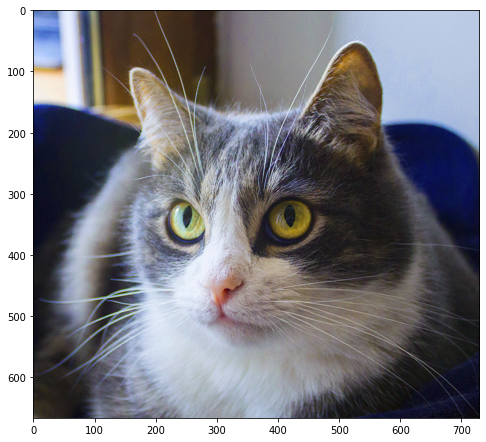

In [2]:
img = imageio.imread('cat-color.png')
img = img / 255

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

Посмотрим на изображение в разных каналах.

Red channel


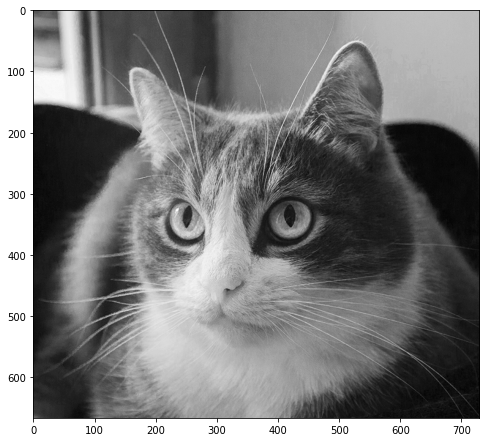

Green channel


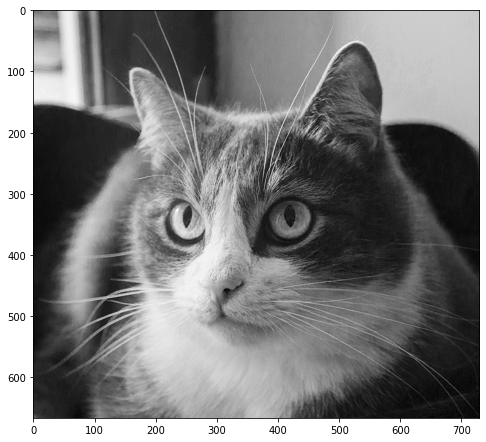

Blue channel


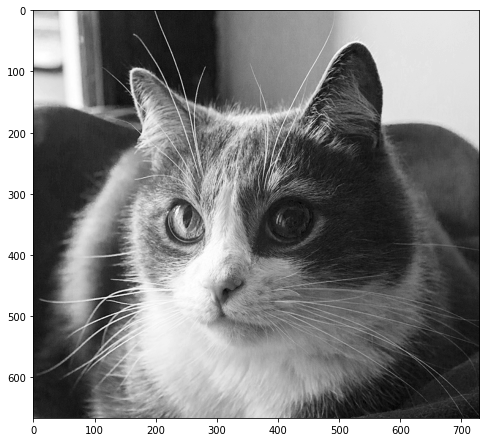

In [3]:
channels = ['Red', 'Green', 'Blue']

for i, c in enumerate(channels):
    plt.figure(figsize=(8, 8))
    print(f'{c} channel')
    plt.imshow(img[..., i], cmap='gray')
    plt.show()

### Цветовые пространства.

Реализуем алгоритм перевода из пространства RGB в пространство HSV

$H \in [0, 360]$

$S, V, R, G, B \in [0, 1]$

$MAX$ - максимальное значение из $R, G$ и $B$, 

$MIN$ - минимальное из них.

$\begin{equation*}
H = 
 \begin{cases}
   60 * \frac{G - B}{MAX - MIN} + 0, &\text{если MAX = R и $G \geq B$}\\
   60 * \frac{G - B}{MAX - MIN} + 360, &\text{если MAX = R и G < B}\\
   60 * \frac{B - R}{MAX - MIN} + 120, &\text{если MAX = G}\\
   60 * \frac{R - G}{MAX - MIN} + 240, &\text{если MAX = B}
 \end{cases}
\end{equation*}$

$\begin{equation*}
S = 
 \begin{cases}
   0, &\text{если MAX = 0}\\
   1 - \frac{MIN}{MAX}, &\text{иначе}
 \end{cases}
\end{equation*}$

$V = MAX$

In [4]:
def hue(img: np.ndarray):
    x = img.copy()
    
    hue = np.zeros(x.shape[:-1])
    
    # минимальные и максимальные значения
    c_min = np.clip(np.min(x, axis=2) - 1e-16, 0, 1)
    c_max = np.clip(np.max(x, axis=2) + 1e-16, 0, 1)
    
    # для удобства разбиваем на каналы
    red = x[..., 0]
    green = x[..., 1]
    blue = x[..., 2]
    
    # по маскам к нулевому массиву прибавляются рассчитанные значения 
    hue += ((np.argmax(img, axis=2) == 0) & (green >= blue)).astype('uint8') * \
            (60 * ((green - blue)/(c_max - c_min)))
    hue += ((np.argmax(img, axis=2) == 0) & (green < blue)).astype('uint8') * \
            (60 * ((green - blue)/(c_max - c_min)) + 360)
    hue += (np.argmax(img, axis=2) == 1).astype('uint8') * \
            (60 * ((blue - red)/(c_max - c_min)) + 120)
    hue += (np.argmax(img, axis=2) == 2).astype('uint8') * \
            (60 * ((red - green)/(c_max - c_min)) + 240)

    return hue / 360


def saturation(img: np.ndarray):
    x = img.copy()
    
    c_min = np.min(x, axis=2)
    c_max = np.max(x, axis=2)

    return (c_max > 0.).astype('uint8') * (1. - (c_min/c_max))


def value(img: np.ndarray):
    x = img.copy()
    return np.max(x, axis=2)


def rgb_to_hsv(img):
    hsv = [hue(img), saturation(img), value(img)]
    hsv = np.stack(hsv, axis=2)
    return hsv

Сравним самописные функции с библиотечной. Сделаем перевод из пространства RGB в HSV и обратно. Обратное преобразование будем осуществлять библиотечной функцией.

In [5]:
from skimage.color import rgb2hsv, hsv2rgb

Самописная функция


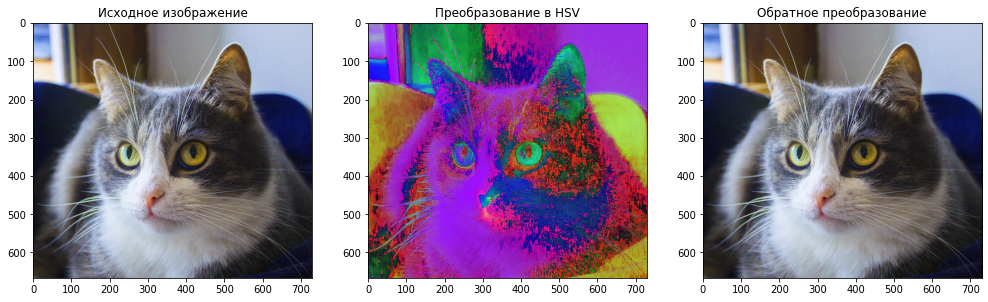

Библиотечная функция


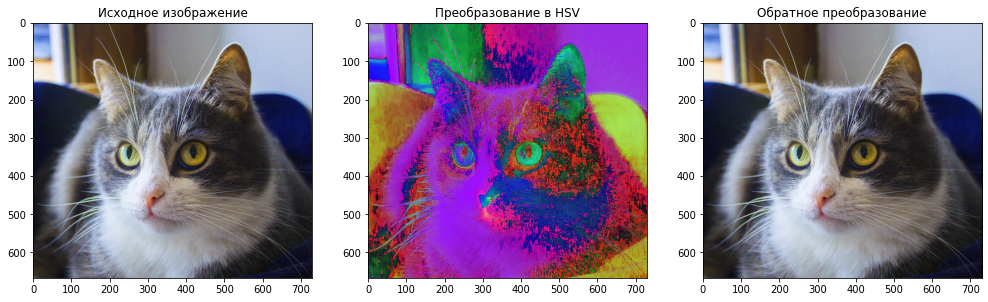

In [6]:
functions = [
    ('Самописная функция', rgb_to_hsv), 
    ('Библиотечная функция', rgb2hsv)
]

for name, func in functions:
    
    hsv = func(img)
    rgb = hsv2rgb(hsv)
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    print(name)
    
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение')
    ax[1].imshow(hsv)
    ax[1].set_title('Преобразование в HSV')
    ax[2].imshow(rgb)
    ax[2].set_title('Обратное преобразование')
    plt.show()

Как видно самописная функция отрабатывает корректно, без каких-то заметных потерь (в сравнении с библиотечной функцией).

Воспользуемся функцией для изменения тона, насыщенности и значения изображения. Будет применятся нелинейное преобразование.

In [7]:
def change_hue(img, value=1):
    hsv = rgb_to_hsv(img)
    hsv[..., 0] = hsv[..., 0] ** value
    return hsv2rgb(hsv)


def change_saturation(img, value=1):
    hsv = rgb_to_hsv(img)
    hsv[..., 1] = hsv[..., 1] ** value
    return hsv2rgb(hsv)


def change_value(img, value=1):
    hsv = rgb_to_hsv(img)
    hsv[..., 2] = hsv[..., 2] ** value
    return hsv2rgb(hsv)

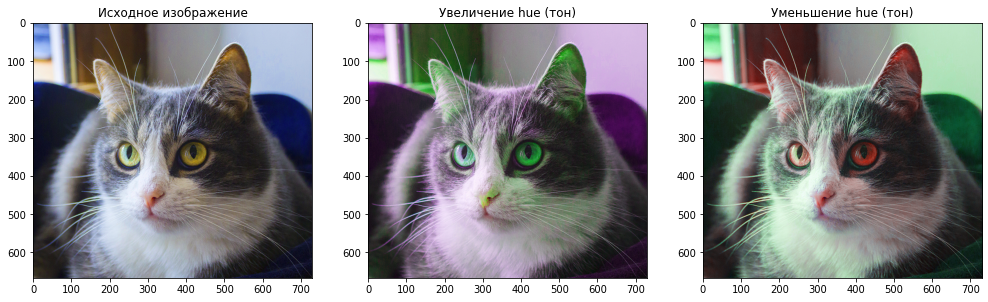

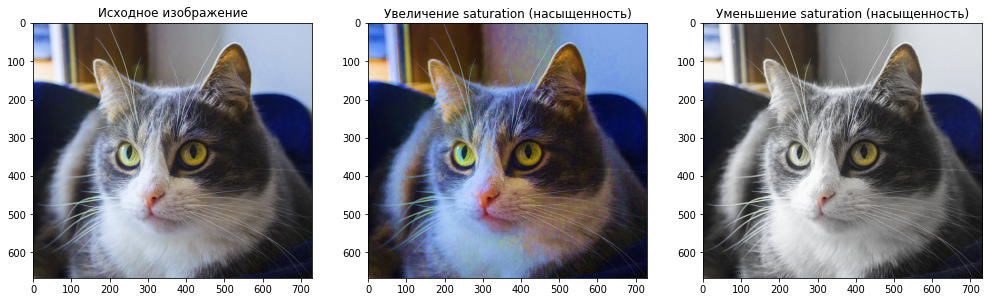

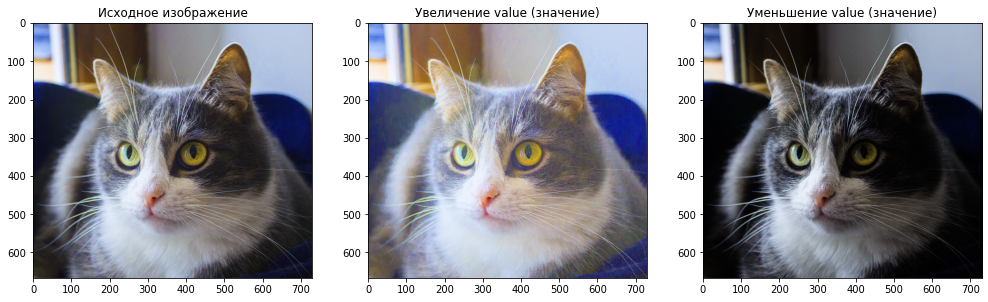

In [8]:
functions = [
    ('hue (тон)', change_hue), 
    ('saturation (насыщенность)', change_saturation), 
    ('value (значение)', change_value)
]

for name, func in functions:
    
    increased = func(img, value=0.5)
    decreased = func(img, value=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение')
    ax[1].imshow(increased)
    ax[1].set_title(f'Увеличение {name}')
    ax[2].imshow(decreased)
    ax[2].set_title(f'Уменьшение {name}')

    plt.show()

### Оконные преобразования.

Размытие изображения.

In [9]:
from scipy import signal


def apply_correlate(img, w):
    out_img = []
    for c in range(img.shape[2]):
        out_img.append(signal.correlate2d(img[..., c], w, mode='valid'))
    out_img = np.stack(out_img, axis=2)
    out_img = np.clip(out_img, 0, 1)
    
    return out_img


def box_blur(img, win_size=(3, 3)):
    '''
    Box размытие изображения. 
    Варьируя win_size можно добиться разного уровня размытия. 
    При большем размере окна размытие будет более явным.
    '''
    w = np.ones(win_size)
    w = w / np.sum(w)
    
    return apply_correlate(img, w)
    

def gaussian_blur(img, win_size=(3, 3), sigma=3):
    '''
    Gaussian размытие изображения. 
    Варьируя win_size можно добиться разного уровня размытия. 
    При большем размере окна размытие будет более явным.
    '''
    w = np.zeros(win_size, dtype=np.float32)
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w[i,j] = np.exp(-(i-w.shape[0]//2)**2 / sigma**2 / 2 
                            -(j-w.shape[1]//2)**2 / sigma**2 / 2)
    w = w / np.sum(w)
    
    return apply_correlate(img, w)

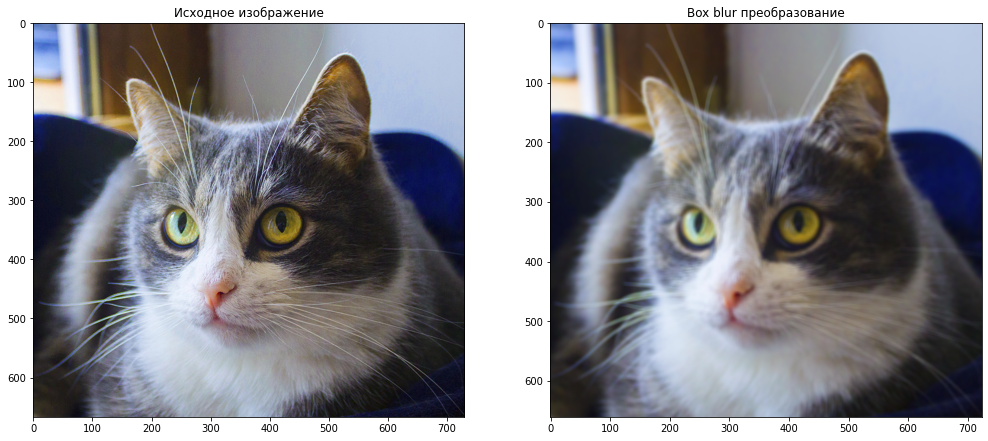

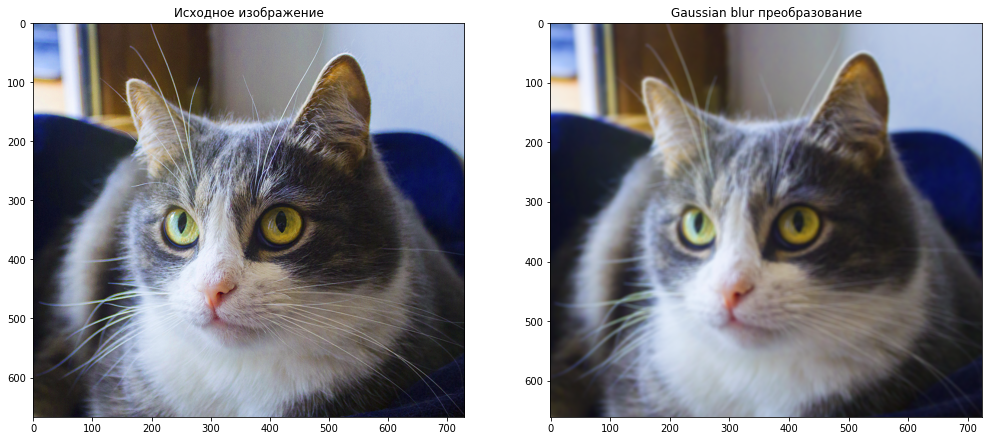

In [10]:
functions = [
    ('Box blur', box_blur), 
    ('Gaussian blur', gaussian_blur)
]

for name, func in functions:
    
    transformed = func(img, win_size=(7, 7))
    
    fig, ax = plt.subplots(1, 2, figsize=(17, 8))
    
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение')
    ax[1].imshow(transformed)
    ax[1].set_title(f'{name} преобразование')

    plt.show()

Выделение контуров.

In [11]:
def vertical(img):
    w = np.zeros((3, 3))
    w[:, 0] = -1
    w[:, -1] = 1
    return apply_correlate(img, w)


def horizontal(img):
    w = np.zeros((3, 3))
    w[0, :] = -1
    w[-1, :] = 1
    return apply_correlate(img, w)


def contour(img, lines='all'):
    
    line_types = {
        'horizontal': (horizontal, ), 
        'vertical': (vertical, ), 
        'all': (vertical, horizontal)
    }
    if lines not in line_types:
        raise ValueError
    output = 0
    
    for line_type in line_types[lines]:
        output += line_type(img)
        
    output = np.clip(output, -1, 1)
    output = (output + 1) / 2
        
    return output

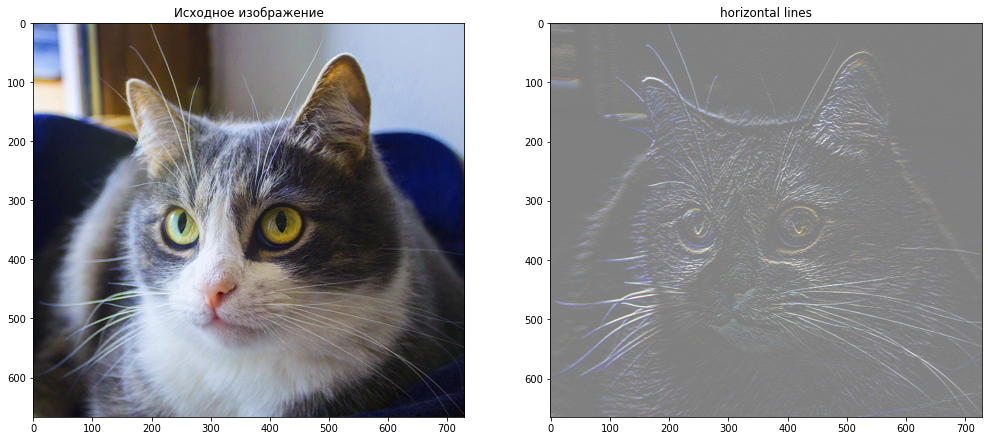

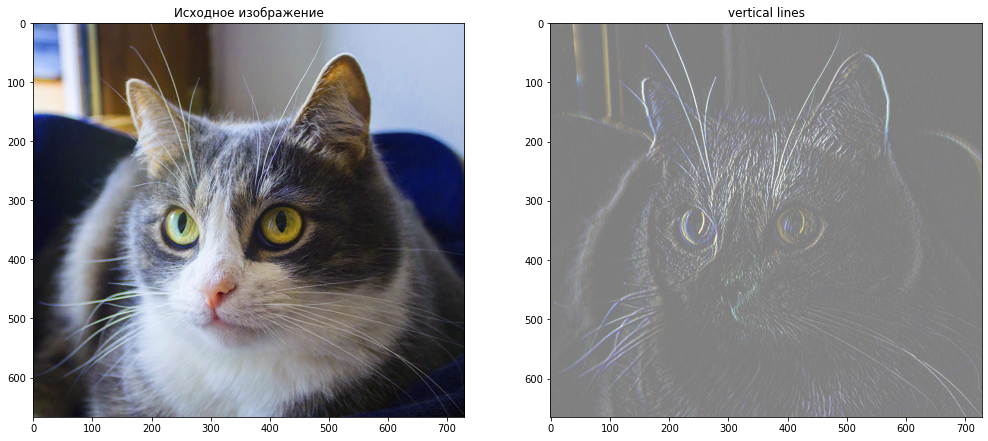

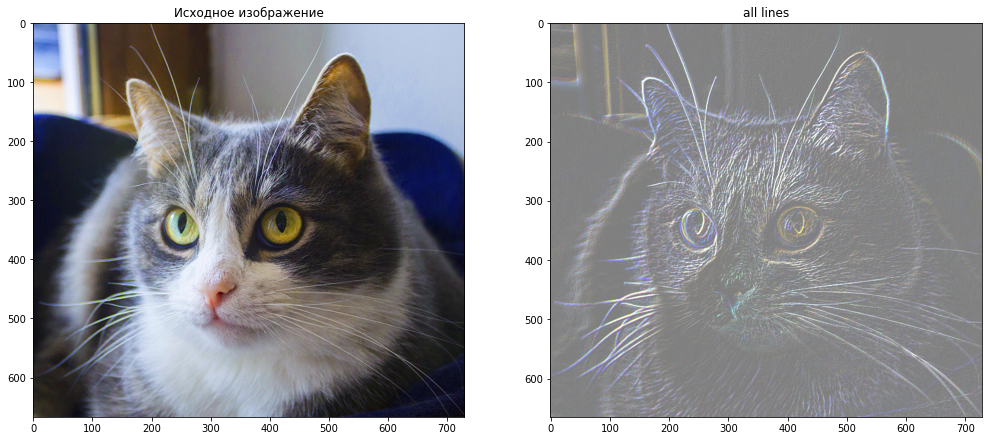

In [12]:
line_types = [
    'horizontal', 
    'vertical', 
    'all'
]

for lines in line_types:
    
    transformed = contour(img, lines=lines)
    
    fig, ax = plt.subplots(1, 2, figsize=(17, 8))
    
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение')
    ax[1].imshow(transformed)
    ax[1].set_title(f'{lines} lines')

    plt.show()